## Visualizing 2P Responses to Stimulus

Some of this content is adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html).

In *2-Photon* Image NWB Files, the data stored measure fluorescence. From the raw 2P images, the The Allen Institute uses the [**Suite2P**](https://github.com/MouseLand/suite2p) segmentation algorithm to identify *regions of interest* (ROIs). For more information on ROIs go to the [Visualizing Raw 2-Photon Images](visualize_2p_raw.ipynb) notebook. For each ROI, two measures of fluorescence are stored; *corrected fluorescence* and *DF/F*. Corrected fluorescence (hereafter referred to as 'fluorescence') is the brightness of the region with unknown units. DF/F is a normalized metric that takes into account baseline fluorescence value in order to provide a measure that can be compared from cell to cell. These traces are stored in the `Processing` section. This notebook uses these fluorescence traces and the stimulus information from the tables in the `Intervals` section of the file to visualize neuron responses to stimulus.

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import fsspec
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from fsspec.implementations.cached import CachingFileSystem
from pynwb import NWBHDF5IO
from scipy import interpolate

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, change `authenticate` to True, and set `dandi_api_key` to your DANDI API key. If you want to stream a file instead of downloading it, checkout Streaming an NWB File with fsspec.

In [3]:
dandiset_id = "000336"
dandi_filepath = "sub_1170622509/sub_1170622509sess_1194683535/sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb"
authenticate = True
dandi_api_key = os.environ["DANDI_API_KEY"]
download_loc = "."

In [4]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [5]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.53.0) of dandi/dandi-cli is available. You are using 0.46.6


Got dandiset DANDI:000336/draft


In [6]:
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

Downloaded file to ./sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb


### Extracting 2P Data and Stimulus Data
Below, the fluorescence traces and timestamps are read from the file's `Processing` section. Note that the exact format to access these traces can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below, as well as the names of all the tables.

In [7]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [8]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

flr = nwb.processing["ophys"]["corrected_fluorescence"]
flr_trace = flr.roi_response_series["traces"].data
flr_timestamps = flr.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(flr_trace.shape)
print(flr_timestamps.shape)
print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)
(42337, 103)
(42337,)


In [9]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_worms_fwd_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations']


In [10]:
stim_table = nwb.intervals['gratings_presentations']
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'color', 'contrast', 'mask', 'opacity', 'ori', 'size', 'units', 'stimulus_index', 'spatial_frequency', 'phase', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,color,contrast,mask,opacity,ori,size,units,stimulus_index,spatial_frequency,phase,tags,timeseries
id,,,,,,,,,,,,,,,,
0,3723.084780,3723.385052,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,60.0,"[250.0, 250.0]",deg,7.0,0.08,0.50,[stimulus_time_interval],"[(222259, 18, timestamps pynwb.base.TimeSeries..."
1,3723.385052,3723.685324,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,90.0,"[250.0, 250.0]",deg,7.0,0.08,0.25,[stimulus_time_interval],"[(222277, 18, timestamps pynwb.base.TimeSeries..."
2,3723.685324,3723.985596,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,150.0,"[250.0, 250.0]",deg,7.0,0.08,0.75,[stimulus_time_interval],"[(222295, 18, timestamps pynwb.base.TimeSeries..."
3,3723.985596,3724.285858,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,120.0,"[250.0, 250.0]",deg,7.0,0.08,0.75,[stimulus_time_interval],"[(222313, 18, timestamps pynwb.base.TimeSeries..."
4,3724.285858,3724.586114,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,0.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(222331, 18, timestamps pynwb.base.TimeSeries..."
5,3724.586114,3724.886369,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,30.0,"[250.0, 250.0]",deg,7.0,0.08,0.75,[stimulus_time_interval],"[(222349, 18, timestamps pynwb.base.TimeSeries..."
6,3724.886369,3725.186622,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,150.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(222367, 18, timestamps pynwb.base.TimeSeries..."
7,3725.186622,3725.486867,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,120.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(222385, 18, timestamps pynwb.base.TimeSeries..."
8,3725.486867,3725.787112,gratings,184.0,"[1.0, 1.0, 1.0]",0.8,None,1.0,60.0,"[250.0, 250.0]",deg,7.0,0.08,0.00,[stimulus_time_interval],"[(222403, 18, timestamps pynwb.base.TimeSeries..."


### Getting Stimulus Epochs
Here, *epochs* are extracted from the stimulus tables. In this case, an epoch is a continuous period of time during a session where a particular type of stimulus is shown. The output here is a list of epochs, where an epoch is a tuple of four values; the stimulus name, the stimulus block, the starting time and the ending time. Since stimulus information can vary signifcantly between experiments and NWB files, you may need to tailor the code below to extract epochs for the file you're interested in.

In [11]:
### extract epoch times from stim table where stimulus rows have a different 'block' than following row
### returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current_epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_block[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_block[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [12]:
### extract epochs from all valid stimulus tables
epochs = []
for stim_name in stimulus_names:
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

185
('movie_touch_of_evil_fwd_presentations', 0.0, 30.02491, 39.03236712068045)
('movie_flower_fwd_presentations', 1.0, 40.03322000000001, 49.04066712068045)
('movie_flower_fwd_presentations', 2.0, 50.041520000000006, 59.04897712068045)
('movie_touch_of_evil_fwd_presentations', 3.0, 60.04983, 69.05729712068045)
('movie_flower_fwd_presentations', 4.0, 70.05813, 79.06559712068045)
('movie_worms_fwd_presentations', 5.0, 80.06644, 89.07389712068046)
('movie_worms_fwd_presentations', 6.0, 90.07477, 99.08223712068045)
('movie_flower_fwd_presentations', 7.0, 100.08306, 109.09053712068044)
('movie_touch_of_evil_fwd_presentations', 8.0, 110.09139, 119.09884712068046)
('movie_worms_fwd_presentations', 9.0, 120.0997, 129.10716712068046)
('movie_touch_of_evil_fwd_presentations', 10.0, 130.10802, 139.11548712068046)
('movie_worms_fwd_presentations', 11.0, 140.11631, 149.12378712068045)
('movie_flower_fwd_presentations', 12.0, 150.12465, 159.13208712068044)
('movie_worms_fwd_presentations', 13.0, 16

### Fluorescence Activity Throughout Epochs
Below is a view of the fluorescence activity of ROIs throughout a session where epochs are shown as colored sections. First, set `trace_to_display` to choose "fluorescence" or "dff". You can view the activity of individual ROIs, all ROIs, or an average of all ROIs. Set `roi_num` to be the ID of the ROI you want to view, or to None to view all ROIs. Alternatively, set `display_average` to True to see the average of all ROIs. Set `time_start` to the starting bound in seconds of the session, you'd like to see, and `time_end` to the ending bound. You may want to use the output above to inform this choice. As mentioned above, if your file's stimulus information differs signifcantly, the plotting code below may need to be modified to appropriately display the epochs.

In [13]:
trace_to_display = "fluorescence" # or "dff"
roi_num = 13 # chosen from flr_trace.shape[1]
display_average_trace = False
time_start = 0
time_end = 1000

In [14]:
### choose data and plot properties based on user input

avg_dff_trace = np.average(dff_trace, axis=1)
avg_flr_trace = np.average(flr_trace, axis=1)

if trace_to_display == "fluorescence":
    plot_title = "Fluorescence Throughout Epochs"
    ylabel = "Fluorescence"
    timestamps = flr_timestamps
    if display_average_trace:
        plot_title = "Average Fluorescence Throughout Epochs"
        ylabel = "Average Fluorescence"
        trace = avg_flr_trace
    elif roi_num:
        trace = flr_trace[:,roi_num]
    else:
        trace = flr_trace

if trace_to_display == "dff":
    plot_title = "DF/F Throughout Epochs"
    ylabel = "DF/F (%)"
    timestamps = dff_timestamps
    if display_average_trace:
        plot_title = "Average DF/F Throughout Epochs"
        ylabel = "Average DF/F (%)"
        trace = avg_dff_trace*100
    elif roi_num:
        trace = dff_trace[:,roi_num]*100
    else:
        trace = dff_trace*100
    # ^^^ * 100 to yield percentage for DF/F

3504.47852446745


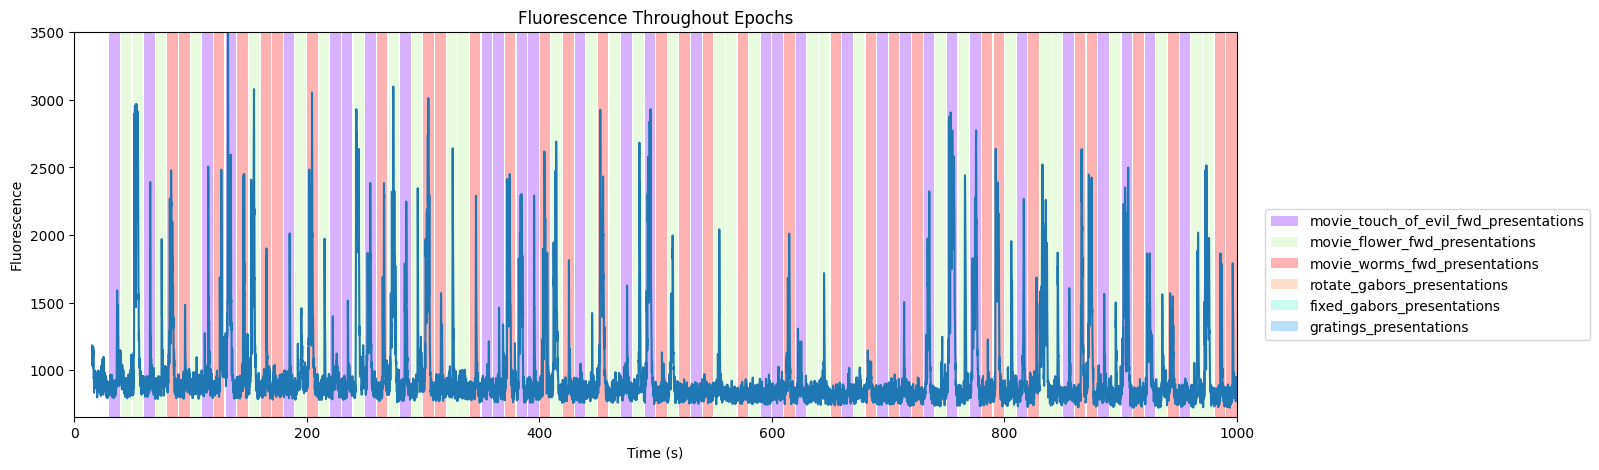

In [15]:
### make plot of chosen fluorescence trace over time with colored epoch sections

fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
y_hi = np.amax(trace) # change these to manually set height of the plot
y_lo = np.amin(trace)
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, y_lo), epoch_end-epoch_start, y_hi, alpha=0.3, facecolor=color))
    epoch_key[stim_name] = rec

ax.set_xlim(time_start, time_end)
ax.set_ylim(y_lo, y_hi)
ax.set_xlabel("Time (s)")
ax.set_ylabel(ylabel)
ax.set_title(plot_title)

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.14, 0.25))
ax.plot(timestamps[:], trace)

print(np.amax(trace))
plt.show()

### Region-wise Fluorescence Over Time
Here a 2D image is made showing ROI fluorescence values over time. Without organizing the ROIs, there are limits to how useful it can be, but it can serve to show responses to stimulus times. Set `trace_to_display` to "fluorescence" or "dff" to select the trace you want to see. Set `interval_start` and `interval_end` to the bounds of time, in seconds, you'd like to see displayed. These bounds get translated into the indices of the trace that match most closely to the time that was provided. If the bounds are outside the measurement period, an error will be thrown. You may also set `start_roi` and `end_roi` to narrow the number of ROIs that will be displayed.

In [16]:
trace_to_display = "fluorescence" # or "dff"
interval_start = 3700
interval_end = 3900
start_roi = 0
end_roi = flr_trace.shape[1] # show all ROIs

In [17]:
# choose plot properties based on user input
if trace_to_display == "fluorescence":
    trace = flr_trace
    timestamps = flr_timestamps
    plot_title = "ROIs Fluorescence Over Time"
    bar_label = "Fluorescence"
if trace_to_display == "dff":
    trace = dff_trace
    timestamps = dff_timestamps
    plot_title = "ROIs DF/F Over Time"
    bar_label = "DF/F (%)"

# translate interval time bounds into approximate data indices
interval_start_idx, interval_end_idx = None, None
for i in range(len(timestamps)):
    if timestamps[i] >= interval_start and not interval_start_idx:
        interval_start_idx = i
    if timestamps[i] >= interval_end and not interval_end_idx:
        interval_end_idx = i
    if interval_start_idx and interval_end_idx:
        break
else:
    raise IndexError("Interval start and Interval end times were not found within the data duration")

if interval_start_idx == interval_end_idx:
    raise IndexError("Interval bounds are equal; Interval has length 0")
    
print(interval_start_idx, interval_end_idx)

39579 41727


Text(0.5, 1.0, 'ROIs Fluorescence Over Time')

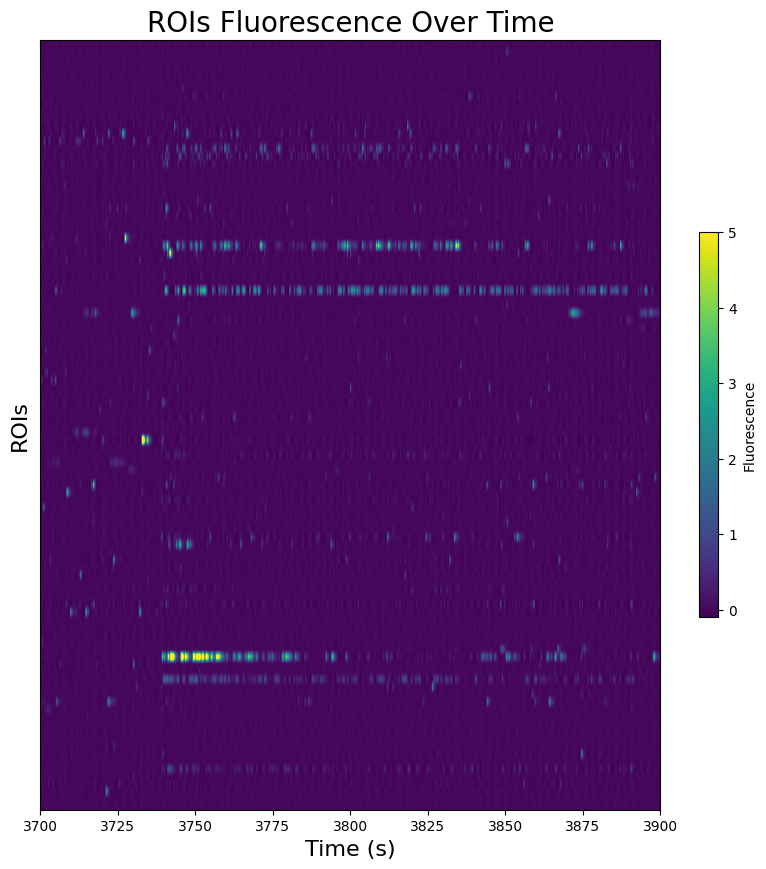

In [18]:
### display array of ROI fluorescence traces as 2D image with color
fig, ax = plt.subplots(figsize=(10,10))

vmin, vmax = 0, 5 # adjust these to change contrast of fluorescence values in the plot
img = ax.imshow(np.transpose(dff_trace[interval_start_idx:interval_end_idx]), extent=[interval_start,interval_end,start_roi,end_roi], aspect='auto', vmax=vmin, vmin=vmax)
cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label(bar_label)

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("ROIs", fontsize=16)
ax.set_xlabel("Time (s)", fontsize=16)
ax.set_title(plot_title, fontsize=20)